In [1]:
import argparse
import sys
import matplotlib
import gym
import torch
from torch.utils.tensorboard import SummaryWriter
import copy
import matplotlib.pyplot as plt
import time
import subprocess
from collections import namedtuple,defaultdict
import logging
import json
import os
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import threading
import random

In [2]:
from utils import *
from memory import *

In [9]:
class RandomAgent(object):
    """The world's simplest agent!"""

    def __init__(self, env, opt):
        self.opt=opt
        self.env=env
        if opt.fromFile is not None:
            self.load(opt.fromFile)
        self.action_space = env.action_space
        self.featureExtractor = opt.featExtractor(env)

    def act(self, observation, reward, done):
        return self.action_space.sample()

    def save(self,outputDir):
        pass

    def load(self,inputDir):
        pass

# Réseau de neurones

In [3]:
class NN(nn.Module):
    def __init__(self, inSize, outSize, layers=[]):
        super(NN, self).__init__()
        self.layers = nn.ModuleList([])
        for x in layers:
            self.layers.append(nn.Linear(inSize, x))
            inSize = x
        self.layers.append(nn.Linear(inSize, outSize))

    def setcuda(self, device):
        self.cuda(device=device)

    def forward(self, x):
        x = self.layers[0](x)
        for i in range(1, len(self.layers)):
            x = torch.tanh(x)
            x = self.layers[i](x)
        return x
    
    def parameters(self):
        return [par for layer in self.layers for par in layer.parameters()]

# DQN

In [4]:
def epsilon_greedy(Q,phi,n,epsilon=0.01, *args):
        rd = random.random()
        if rd<epsilon:
            return np.random.randint(n)
        with torch.no_grad():
            return torch.argmax(Q(phi))

class DQN:
    def __init__(self,env,capacity,insize,layers,config,mini_batch_size,C,device,lr,prior=False,discount=0.999,choice=epsilon_greedy):
        self.device = device
        self.env = env
        self.action_space = env.action_space.n
        self.capacity = capacity
        self.prior = prior
        self.D = Memory(capacity, prior=self.prior)
        self.Q = NN(insize, self.action_space, layers).to(self.device)
        self.Qpred = copy.deepcopy(self.Q)
        self.choice = choice
        self.discount = discount
        self.count = 0
        self.st = None
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr = self.lr)
        self.mini_batch_size = mini_batch_size
        self.loss = torch.nn.SmoothL1Loss()
        self.C = C
        self.fe = config["featExtractor"](env)
        
    
        
    def act(self, observation, reward, done):
        reward = torch.tensor(reward, dtype=torch.float32)
        observation = torch.tensor(observation, dtype=torch.float32, requires_grad=True).to(self.device)
        phi = torch.tensor(self.fe.getFeatures(observation), dtype=torch.float32, requires_grad=True).to(self.device)
        action = torch.tensor(self.choice(self.Q, phi, self.action_space, epsilon=0.01 * (0.99999 ** self.count))).to(self.device)
        if self.st is not None:
            self.count += 1
            if done:
                yj = torch.tensor(reward, dtype=torch.float32, requires_grad=True).to(self.device)
            else:
                yj = torch.tensor(reward + self.discount * torch.max(self.Qpred(phi)), dtype=torch.float32, requires_grad=True).to(self.device)
            #Stockage de la transition
            self.D.store((self.st,self.at,self.rt,phi,yj))
            if self.count >= self.mini_batch_size: #On remplit le buffer avant d'optimiser
                if self.prior: #Prioritized experience replay
                    idx, w, mini_batch = self.D.sample(self.mini_batch_size)
                else: #Simple experience replay
                    mini_batch = self.D.sample(self.mini_batch_size)
                try:
                    st_temp, action_temp, reward_temp, next_st_temp, yj_temp = zip(*mini_batch)
                except TypeError: #J'ai cette erreur seulement dans la version prioritized (prior=True), je corrigerais
                    print("mini batch",mini_batch)
                    print("last element",mini_batch[-1])
                    print("mini batch shape",mini_batch.shape)
                st_temp = torch.stack(st_temp)
                next_st_temp = torch.stack(next_st_temp)
                action_temp = torch.stack(action_temp)
                reward_temp = torch.stack(reward_temp).view(-1,1)
                self.optimizer.zero_grad()
                #Prédiction sur les états du mini-batch (et les actions associées), version vectorisée
                pred = self.Q(st_temp).gather(1,torch.tensor(action_temp.view(-1,1))).view(self.mini_batch_size).to(self.device)
                y = torch.stack(yj_temp).to(self.device)
                loss = self.loss(pred,y)
                loss.backward()
                self.optimizer.step() 
                if self.prior: #Mise à jour des poids pour le prioritized experience replay
                    idx = np.array(idx)
                    qmax = torch.max(self.Q(next_st_temp), dim=1)[0].view(-1,1)
                    q = self.Q(st_temp).gather(1,torch.tensor(action_temp.view(-1,1))).view(-1,1)
                    tderr = ((qmax + reward_temp - q).clone().detach().numpy())**2               
                    self.D.update(idx, tderr*w)
                if self.count % self.C == 0:
                    self.Qpred = copy.deepcopy(self.Q)
        #Stockage de state, action, reward
        self.st = phi
        self.at = action
        self.rt = reward
        self.done = done
        return int(action)

In [5]:
def runDQN(config, device, nb_epochs, capacity=10000, layers=[30,30], mini_batch_size=128, C=5000, lr=0.001):
    envName = config["env"]
    if envName == "CartPole-v1":
        insize = 4
    if envName == "LunarLander-v2":
        insize = 8
    freqTest = 10
    freqSave = config["freqSave"]
    nbTest = 100
    env = gym.make(config["env"])
    if hasattr(env, 'setPlan'):
        env.setPlan(config["map"], config["rewards"])
    tstart = str(time.time())
    tstart = tstart.replace(".", "_")
    outdir = "./XP/" + config["env"] + "/random_" + "-" + tstart
    env.seed(config["seed"])
    np.random.seed(config["seed"])
    torch.manual_seed(config["seed"])
    episode_count = config["nbEpisodes"]
    ob = env.reset()
    agent = DQN(env,capacity=10000,insize=insize,layers=layers,config=config,mini_batch_size=mini_batch_size, C=C, device=device, lr=lr)
    print("Saving in " + outdir)
    os.makedirs(outdir, exist_ok=True)
    save_src(os.path.abspath(outdir))
    write_yaml(os.path.join(outdir, 'info.yaml'), config)
    logger = LogMe(SummaryWriter(outdir))
    loadTensorBoard(outdir)
    rsum = 0
    mean = 0
    verbose = True
    itest = 0
    reward = 0
    done = False
    arrReward = []
    arrMeanReward = []
    for i in range(nb_epochs):
        if i % int(config["freqVerbose"]) == 0 and i >= config["freqVerbose"]:
            verbose = False
        else:
            verbose = False
        if i % freqTest == 0 and i >= freqTest:  ##### Same as train for now
            print("End of test, mean reward over the last {} actions: {}".format(nbTest,mean / nbTest))
            arrMeanReward.append(mean / nbTest)
            itest += 1
            print("New test time! ")
            mean = 0
            #agent.test = True

        """if i % freqTest == nbTest and i > freqTest:
            #logger.direct_write("rewardTest", mean / nbTest, itest)
            agent.test = False"""
            
        """if i % freqSave == 0:
            agent.save(outdir + "/save_" + str(i))"""

        j = 0
        if verbose:
            env.render()

        while True:
            if verbose:
                env.render()

            action = agent.act(ob, reward, done)
            ob, reward, done, _ = env.step(action)
            j+=1

            rsum += reward
            if done:
                print(str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions ")
                #logger.direct_write("reward", rsum, i)
                arrReward.append(rsum)
                agent.nbEvents = 0
                mean += rsum
                rsum = 0
                ob = env.reset()
                break
    env.close()
    plt.plot([i for i in range(len(arrReward))],arrReward,label="Reward")
    plt.plot([i*nbTest for i in range(1,itest+1)],arrMeanReward,label="Mean reward over {} epochs".format(nbTest))
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.title("Algorithme DQN, monde {}".format(envName))
    plt.legend()
    plt.show()
    return arrReward, arrMeanReward

# Campagne d'expérimentations

Saving in ./XP/CartPole-v1/random_-1605465916_2307572
tensorboard --logdir=./XP/CartPole-v1/random_-1605465916_2307572
0 rsum=37.0, 37 actions 
1 rsum=69.0, 69 actions 
2 rsum=32.0, 32 actions 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

3 rsum=44.0, 44 actions 
4 rsum=39.0, 39 actions 
5 rsum=21.0, 21 actions 
6 rsum=16.0, 16 actions 
7 rsum=19.0, 19 actions 
8 rsum=17.0, 17 actions 
9 rsum=15.0, 15 actions 
End of test, mean reward over the last 10 actions: 30.9
New test time! 
10 rsum=15.0, 15 actions 
11 rsum=16.0, 16 actions 
12 rsum=14.0, 14 actions 
13 rsum=14.0, 14 actions 
14 rsum=17.0, 17 actions 
15 rsum=12.0, 12 actions 
16 rsum=11.0, 11 actions 
17 rsum=13.0, 13 actions 
18 rsum=12.0, 12 actions 
19 rsum=10.0, 10 actions 
End of test, mean reward over the last 10 actions: 13.4
New test time! 
20 rsum=11.0, 11 actions 
21 rsum=12.0, 12 actions 
22 rsum=11.0, 11 actions 
23 rsum=9.0, 9 actions 
24 rsum=10.0, 10 actions 
25 rsum=8.0, 8 actions 
26 rsum=10.0, 10 actions 
27 rsum=9.0, 9 actions 
28 rsum=9.0, 9 actions 
29 rsum=9.0, 9 actions 
End of test, mean reward over the last 10 actions: 9.8
New test time! 
30 rsum=10.0, 10 actions 
31 rsum=10.0, 10 actions 
32 rsum=10.0, 10 actions 
33 rsum=9.0, 9 actions

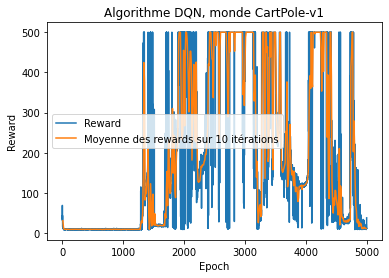

In [34]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
#config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 8000
arrReward, arrMeanReward = runDQN(config, device, nb_epochs, capacity=10000, layers=[32,32], mini_batch_size=64, C=1000, lr=0.001)

Saving in ./XP/CartPole-v1/random_-1614552989_1071115
tensorboard --logdir=./XP/CartPole-v1/random_-1614552989_1071115
0 rsum=37.0, 37 actions 


/home/yass/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yass/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yass/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yass/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

1 rsum=65.0, 65 actions 
2 rsum=34.0, 34 actions 
3 rsum=43.0, 43 actions 
4 rsum=39.0, 39 actions 
5 rsum=22.0, 22 actions 
6 rsum=18.0, 18 actions 
7 rsum=20.0, 20 actions 
8 rsum=17.0, 17 actions 
9 rsum=15.0, 15 actions 
End of test, mean reward over the last 100 actions: 3.1
New test time! 
10 rsum=15.0, 15 actions 
11 rsum=16.0, 16 actions 
12 rsum=14.0, 14 actions 
13 rsum=14.0, 14 actions 
14 rsum=16.0, 16 actions 
15 rsum=11.0, 11 actions 
16 rsum=11.0, 11 actions 
17 rsum=13.0, 13 actions 
18 rsum=11.0, 11 actions 
19 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 1.31
New test time! 
20 rsum=10.0, 10 actions 
21 rsum=11.0, 11 actions 
22 rsum=11.0, 11 actions 
23 rsum=9.0, 9 actions 
24 rsum=10.0, 10 actions 
25 rsum=8.0, 8 actions 
26 rsum=10.0, 10 actions 
27 rsum=9.0, 9 actions 
28 rsum=10.0, 10 actions 
29 rsum=9.0, 9 actions 
End of test, mean reward over the last 100 actions: 0.97
New test time! 
30 rsum=10.0, 10 actions 
31 rsum=10.0, 10 ac

253 rsum=9.0, 9 actions 
254 rsum=10.0, 10 actions 
255 rsum=9.0, 9 actions 
256 rsum=9.0, 9 actions 
257 rsum=11.0, 11 actions 
258 rsum=9.0, 9 actions 
259 rsum=9.0, 9 actions 
End of test, mean reward over the last 100 actions: 0.94
New test time! 
260 rsum=9.0, 9 actions 
261 rsum=10.0, 10 actions 
262 rsum=11.0, 11 actions 
263 rsum=11.0, 11 actions 
264 rsum=8.0, 8 actions 
265 rsum=9.0, 9 actions 
266 rsum=10.0, 10 actions 
267 rsum=10.0, 10 actions 
268 rsum=8.0, 8 actions 
269 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.96
New test time! 
270 rsum=9.0, 9 actions 
271 rsum=11.0, 11 actions 
272 rsum=8.0, 8 actions 
273 rsum=10.0, 10 actions 
274 rsum=9.0, 9 actions 
275 rsum=9.0, 9 actions 
276 rsum=10.0, 10 actions 
277 rsum=8.0, 8 actions 
278 rsum=9.0, 9 actions 
279 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.93
New test time! 
280 rsum=10.0, 10 actions 
281 rsum=10.0, 10 actions 
282 rsum=9.0, 9 actions 
283

503 rsum=10.0, 10 actions 
504 rsum=9.0, 9 actions 
505 rsum=10.0, 10 actions 
506 rsum=10.0, 10 actions 
507 rsum=10.0, 10 actions 
508 rsum=10.0, 10 actions 
509 rsum=9.0, 9 actions 
End of test, mean reward over the last 100 actions: 0.94
New test time! 
510 rsum=10.0, 10 actions 
511 rsum=9.0, 9 actions 
512 rsum=11.0, 11 actions 
513 rsum=9.0, 9 actions 
514 rsum=10.0, 10 actions 
515 rsum=9.0, 9 actions 
516 rsum=9.0, 9 actions 
517 rsum=10.0, 10 actions 
518 rsum=10.0, 10 actions 
519 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.97
New test time! 
520 rsum=10.0, 10 actions 
521 rsum=9.0, 9 actions 
522 rsum=10.0, 10 actions 
523 rsum=10.0, 10 actions 
524 rsum=10.0, 10 actions 
525 rsum=8.0, 8 actions 
526 rsum=9.0, 9 actions 
527 rsum=10.0, 10 actions 
528 rsum=10.0, 10 actions 
529 rsum=9.0, 9 actions 
End of test, mean reward over the last 100 actions: 0.95
New test time! 
530 rsum=9.0, 9 actions 
531 rsum=10.0, 10 actions 
532 rsum=9.0, 9 acti

754 rsum=10.0, 10 actions 
755 rsum=10.0, 10 actions 
756 rsum=9.0, 9 actions 
757 rsum=9.0, 9 actions 
758 rsum=9.0, 9 actions 
759 rsum=11.0, 11 actions 
End of test, mean reward over the last 100 actions: 0.95
New test time! 
760 rsum=10.0, 10 actions 
761 rsum=9.0, 9 actions 
762 rsum=9.0, 9 actions 
763 rsum=10.0, 10 actions 
764 rsum=10.0, 10 actions 
765 rsum=10.0, 10 actions 
766 rsum=10.0, 10 actions 
767 rsum=11.0, 11 actions 
768 rsum=10.0, 10 actions 
769 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.99
New test time! 
770 rsum=9.0, 9 actions 
771 rsum=9.0, 9 actions 
772 rsum=8.0, 8 actions 
773 rsum=10.0, 10 actions 
774 rsum=10.0, 10 actions 
775 rsum=8.0, 8 actions 
776 rsum=10.0, 10 actions 
777 rsum=10.0, 10 actions 
778 rsum=9.0, 9 actions 
779 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.93
New test time! 
780 rsum=10.0, 10 actions 
781 rsum=10.0, 10 actions 
782 rsum=10.0, 10 actions 
783 rsum=9.0, 9 ac

1004 rsum=9.0, 9 actions 
1005 rsum=8.0, 8 actions 
1006 rsum=9.0, 9 actions 
1007 rsum=10.0, 10 actions 
1008 rsum=10.0, 10 actions 
1009 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.93
New test time! 
1010 rsum=10.0, 10 actions 
1011 rsum=9.0, 9 actions 
1012 rsum=10.0, 10 actions 
1013 rsum=10.0, 10 actions 
1014 rsum=10.0, 10 actions 
1015 rsum=9.0, 9 actions 
1016 rsum=10.0, 10 actions 
1017 rsum=9.0, 9 actions 
1018 rsum=10.0, 10 actions 
1019 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.97
New test time! 
1020 rsum=10.0, 10 actions 
1021 rsum=10.0, 10 actions 
1022 rsum=9.0, 9 actions 
1023 rsum=10.0, 10 actions 
1024 rsum=9.0, 9 actions 
1025 rsum=10.0, 10 actions 
1026 rsum=10.0, 10 actions 
1027 rsum=9.0, 9 actions 
1028 rsum=10.0, 10 actions 
1029 rsum=8.0, 8 actions 
End of test, mean reward over the last 100 actions: 0.95
New test time! 
1030 rsum=8.0, 8 actions 
1031 rsum=9.0, 9 actions 
1032 rsum=9.0, 9 acti

1245 rsum=10.0, 10 actions 
1246 rsum=10.0, 10 actions 
1247 rsum=9.0, 9 actions 
1248 rsum=9.0, 9 actions 
1249 rsum=12.0, 12 actions 
End of test, mean reward over the last 100 actions: 0.94
New test time! 
1250 rsum=9.0, 9 actions 
1251 rsum=10.0, 10 actions 
1252 rsum=10.0, 10 actions 
1253 rsum=10.0, 10 actions 
1254 rsum=8.0, 8 actions 
1255 rsum=11.0, 11 actions 
1256 rsum=10.0, 10 actions 
1257 rsum=9.0, 9 actions 
1258 rsum=9.0, 9 actions 
1259 rsum=9.0, 9 actions 
End of test, mean reward over the last 100 actions: 0.95
New test time! 
1260 rsum=8.0, 8 actions 
1261 rsum=9.0, 9 actions 
1262 rsum=10.0, 10 actions 
1263 rsum=10.0, 10 actions 
1264 rsum=9.0, 9 actions 
1265 rsum=10.0, 10 actions 
1266 rsum=9.0, 9 actions 
1267 rsum=10.0, 10 actions 
1268 rsum=10.0, 10 actions 
1269 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.95
New test time! 
1270 rsum=10.0, 10 actions 
1271 rsum=10.0, 10 actions 
1272 rsum=9.0, 9 actions 
1273 rsum=9.0, 9 acti

1484 rsum=64.0, 64 actions 
1485 rsum=108.0, 108 actions 
1486 rsum=82.0, 82 actions 
1487 rsum=58.0, 58 actions 
1488 rsum=500.0, 500 actions 
1489 rsum=224.0, 224 actions 
End of test, mean reward over the last 100 actions: 12.64
New test time! 
1490 rsum=254.0, 254 actions 
1491 rsum=105.0, 105 actions 
1492 rsum=102.0, 102 actions 
1493 rsum=221.0, 221 actions 
1494 rsum=216.0, 216 actions 
1495 rsum=100.0, 100 actions 
1496 rsum=208.0, 208 actions 
1497 rsum=233.0, 233 actions 
1498 rsum=219.0, 219 actions 
1499 rsum=199.0, 199 actions 
End of test, mean reward over the last 100 actions: 18.57
New test time! 
1500 rsum=214.0, 214 actions 
1501 rsum=330.0, 330 actions 
1502 rsum=361.0, 361 actions 
1503 rsum=500.0, 500 actions 
1504 rsum=500.0, 500 actions 
1505 rsum=500.0, 500 actions 
1506 rsum=500.0, 500 actions 
1507 rsum=500.0, 500 actions 
1508 rsum=500.0, 500 actions 
1509 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 44.05
New test time! 
1510

1721 rsum=10.0, 10 actions 
1722 rsum=10.0, 10 actions 
1723 rsum=10.0, 10 actions 
1724 rsum=9.0, 9 actions 
1725 rsum=10.0, 10 actions 
1726 rsum=9.0, 9 actions 
1727 rsum=9.0, 9 actions 
1728 rsum=10.0, 10 actions 
1729 rsum=9.0, 9 actions 
End of test, mean reward over the last 100 actions: 0.94
New test time! 
1730 rsum=9.0, 9 actions 
1731 rsum=10.0, 10 actions 
1732 rsum=10.0, 10 actions 
1733 rsum=9.0, 9 actions 
1734 rsum=10.0, 10 actions 
1735 rsum=10.0, 10 actions 
1736 rsum=9.0, 9 actions 
1737 rsum=9.0, 9 actions 
1738 rsum=10.0, 10 actions 
1739 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.96
New test time! 
1740 rsum=10.0, 10 actions 
1741 rsum=9.0, 9 actions 
1742 rsum=8.0, 8 actions 
1743 rsum=10.0, 10 actions 
1744 rsum=10.0, 10 actions 
1745 rsum=9.0, 9 actions 
1746 rsum=9.0, 9 actions 
1747 rsum=10.0, 10 actions 
1748 rsum=10.0, 10 actions 
1749 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.95
New test 

1961 rsum=10.0, 10 actions 
1962 rsum=9.0, 9 actions 
1963 rsum=8.0, 8 actions 
1964 rsum=8.0, 8 actions 
1965 rsum=9.0, 9 actions 
1966 rsum=10.0, 10 actions 
1967 rsum=10.0, 10 actions 
1968 rsum=9.0, 9 actions 
1969 rsum=10.0, 10 actions 
End of test, mean reward over the last 100 actions: 0.93
New test time! 
1970 rsum=8.0, 8 actions 
1971 rsum=8.0, 8 actions 
1972 rsum=10.0, 10 actions 
1973 rsum=8.0, 8 actions 
1974 rsum=10.0, 10 actions 
1975 rsum=9.0, 9 actions 
1976 rsum=9.0, 9 actions 
1977 rsum=10.0, 10 actions 
1978 rsum=11.0, 11 actions 
1979 rsum=9.0, 9 actions 
End of test, mean reward over the last 100 actions: 0.92
New test time! 
1980 rsum=9.0, 9 actions 
1981 rsum=10.0, 10 actions 
1982 rsum=10.0, 10 actions 
1983 rsum=11.0, 11 actions 
1984 rsum=9.0, 9 actions 
1985 rsum=10.0, 10 actions 
1986 rsum=10.0, 10 actions 
1987 rsum=10.0, 10 actions 
1988 rsum=9.0, 9 actions 
1989 rsum=9.0, 9 actions 
End of test, mean reward over the last 100 actions: 0.97
New test time! 

2200 rsum=56.0, 56 actions 
2201 rsum=59.0, 59 actions 
2202 rsum=54.0, 54 actions 
2203 rsum=71.0, 71 actions 
2204 rsum=52.0, 52 actions 
2205 rsum=62.0, 62 actions 
2206 rsum=76.0, 76 actions 
2207 rsum=60.0, 60 actions 
2208 rsum=58.0, 58 actions 
2209 rsum=53.0, 53 actions 
End of test, mean reward over the last 100 actions: 6.01
New test time! 
2210 rsum=63.0, 63 actions 
2211 rsum=61.0, 61 actions 
2212 rsum=60.0, 60 actions 
2213 rsum=63.0, 63 actions 
2214 rsum=66.0, 66 actions 
2215 rsum=62.0, 62 actions 
2216 rsum=46.0, 46 actions 
2217 rsum=60.0, 60 actions 
2218 rsum=54.0, 54 actions 
2219 rsum=74.0, 74 actions 
End of test, mean reward over the last 100 actions: 6.09
New test time! 
2220 rsum=68.0, 68 actions 
2221 rsum=53.0, 53 actions 
2222 rsum=84.0, 84 actions 
2223 rsum=68.0, 68 actions 
2224 rsum=48.0, 48 actions 
2225 rsum=70.0, 70 actions 
2226 rsum=46.0, 46 actions 
2227 rsum=74.0, 74 actions 
2228 rsum=53.0, 53 actions 
2229 rsum=63.0, 63 actions 
End of test, m

2429 rsum=135.0, 135 actions 
End of test, mean reward over the last 100 actions: 24.78
New test time! 
2430 rsum=159.0, 159 actions 
2431 rsum=166.0, 166 actions 
2432 rsum=144.0, 144 actions 
2433 rsum=153.0, 153 actions 
2434 rsum=126.0, 126 actions 
2435 rsum=131.0, 131 actions 
2436 rsum=98.0, 98 actions 
2437 rsum=175.0, 175 actions 
2438 rsum=128.0, 128 actions 
2439 rsum=113.0, 113 actions 
End of test, mean reward over the last 100 actions: 13.93
New test time! 
2440 rsum=127.0, 127 actions 
2441 rsum=500.0, 500 actions 
2442 rsum=127.0, 127 actions 
2443 rsum=139.0, 139 actions 
2444 rsum=119.0, 119 actions 
2445 rsum=121.0, 121 actions 
2446 rsum=156.0, 156 actions 
2447 rsum=189.0, 189 actions 
2448 rsum=120.0, 120 actions 
2449 rsum=108.0, 108 actions 
End of test, mean reward over the last 100 actions: 17.06
New test time! 
2450 rsum=177.0, 177 actions 
2451 rsum=128.0, 128 actions 
2452 rsum=138.0, 138 actions 
2453 rsum=145.0, 145 actions 
2454 rsum=158.0, 158 actions 


2650 rsum=180.0, 180 actions 
2651 rsum=184.0, 184 actions 
2652 rsum=299.0, 299 actions 
2653 rsum=242.0, 242 actions 
2654 rsum=151.0, 151 actions 
2655 rsum=160.0, 160 actions 
2656 rsum=334.0, 334 actions 
2657 rsum=163.0, 163 actions 
2658 rsum=327.0, 327 actions 
2659 rsum=164.0, 164 actions 
End of test, mean reward over the last 100 actions: 22.04
New test time! 
2660 rsum=302.0, 302 actions 
2661 rsum=366.0, 366 actions 
2662 rsum=299.0, 299 actions 
2663 rsum=166.0, 166 actions 
2664 rsum=151.0, 151 actions 
2665 rsum=242.0, 242 actions 
2666 rsum=215.0, 215 actions 
2667 rsum=150.0, 150 actions 
2668 rsum=165.0, 165 actions 
2669 rsum=159.0, 159 actions 
End of test, mean reward over the last 100 actions: 22.15
New test time! 
2670 rsum=219.0, 219 actions 
2671 rsum=176.0, 176 actions 
2672 rsum=179.0, 179 actions 
2673 rsum=189.0, 189 actions 
2674 rsum=147.0, 147 actions 
2675 rsum=238.0, 238 actions 
2676 rsum=369.0, 369 actions 
2677 rsum=212.0, 212 actions 
2678 rsum=15

2870 rsum=132.0, 132 actions 
2871 rsum=15.0, 15 actions 
2872 rsum=140.0, 140 actions 
2873 rsum=132.0, 132 actions 
2874 rsum=144.0, 144 actions 
2875 rsum=116.0, 116 actions 
2876 rsum=125.0, 125 actions 
2877 rsum=14.0, 14 actions 
2878 rsum=133.0, 133 actions 
2879 rsum=130.0, 130 actions 
End of test, mean reward over the last 100 actions: 10.81
New test time! 
2880 rsum=129.0, 129 actions 
2881 rsum=142.0, 142 actions 
2882 rsum=118.0, 118 actions 
2883 rsum=135.0, 135 actions 
2884 rsum=131.0, 131 actions 
2885 rsum=108.0, 108 actions 
2886 rsum=16.0, 16 actions 
2887 rsum=108.0, 108 actions 
2888 rsum=128.0, 128 actions 
2889 rsum=123.0, 123 actions 
End of test, mean reward over the last 100 actions: 11.38
New test time! 
2890 rsum=112.0, 112 actions 
2891 rsum=112.0, 112 actions 
2892 rsum=117.0, 117 actions 
2893 rsum=14.0, 14 actions 
2894 rsum=117.0, 117 actions 
2895 rsum=135.0, 135 actions 
2896 rsum=121.0, 121 actions 
2897 rsum=103.0, 103 actions 
2898 rsum=116.0, 116

3096 rsum=171.0, 171 actions 
3097 rsum=62.0, 62 actions 
3098 rsum=67.0, 67 actions 
3099 rsum=118.0, 118 actions 
End of test, mean reward over the last 100 actions: 9.66
New test time! 
3100 rsum=120.0, 120 actions 
3101 rsum=62.0, 62 actions 
3102 rsum=118.0, 118 actions 
3103 rsum=120.0, 120 actions 
3104 rsum=117.0, 117 actions 
3105 rsum=123.0, 123 actions 
3106 rsum=173.0, 173 actions 
3107 rsum=121.0, 121 actions 
3108 rsum=128.0, 128 actions 
3109 rsum=118.0, 118 actions 
End of test, mean reward over the last 100 actions: 12.0
New test time! 
3110 rsum=63.0, 63 actions 
3111 rsum=133.0, 133 actions 
3112 rsum=174.0, 174 actions 
3113 rsum=177.0, 177 actions 
3114 rsum=354.0, 354 actions 
3115 rsum=448.0, 448 actions 
3116 rsum=127.0, 127 actions 
3117 rsum=270.0, 270 actions 
3118 rsum=143.0, 143 actions 
3119 rsum=146.0, 146 actions 
End of test, mean reward over the last 100 actions: 20.35
New test time! 
3120 rsum=242.0, 242 actions 
3121 rsum=115.0, 115 actions 
3122 rsu

3317 rsum=119.0, 119 actions 
3318 rsum=123.0, 123 actions 
3319 rsum=123.0, 123 actions 
End of test, mean reward over the last 100 actions: 12.97
New test time! 
3320 rsum=116.0, 116 actions 
3321 rsum=119.0, 119 actions 
3322 rsum=121.0, 121 actions 
3323 rsum=110.0, 110 actions 
3324 rsum=115.0, 115 actions 
3325 rsum=124.0, 124 actions 
3326 rsum=125.0, 125 actions 
3327 rsum=117.0, 117 actions 
3328 rsum=120.0, 120 actions 
3329 rsum=113.0, 113 actions 
End of test, mean reward over the last 100 actions: 11.8
New test time! 
3330 rsum=126.0, 126 actions 
3331 rsum=113.0, 113 actions 
3332 rsum=119.0, 119 actions 
3333 rsum=122.0, 122 actions 
3334 rsum=119.0, 119 actions 
3335 rsum=122.0, 122 actions 
3336 rsum=121.0, 121 actions 
3337 rsum=130.0, 130 actions 
3338 rsum=121.0, 121 actions 
3339 rsum=126.0, 126 actions 
End of test, mean reward over the last 100 actions: 12.19
New test time! 
3340 rsum=127.0, 127 actions 
3341 rsum=126.0, 126 actions 
3342 rsum=124.0, 124 actions 

3537 rsum=500.0, 500 actions 
3538 rsum=500.0, 500 actions 
3539 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 39.93
New test time! 
3540 rsum=500.0, 500 actions 
3541 rsum=500.0, 500 actions 
3542 rsum=500.0, 500 actions 
3543 rsum=500.0, 500 actions 
3544 rsum=500.0, 500 actions 
3545 rsum=500.0, 500 actions 
3546 rsum=500.0, 500 actions 
3547 rsum=500.0, 500 actions 
3548 rsum=500.0, 500 actions 
3549 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 50.0
New test time! 
3550 rsum=500.0, 500 actions 
3551 rsum=500.0, 500 actions 
3552 rsum=500.0, 500 actions 
3553 rsum=500.0, 500 actions 
3554 rsum=500.0, 500 actions 
3555 rsum=500.0, 500 actions 
3556 rsum=500.0, 500 actions 
3557 rsum=500.0, 500 actions 
3558 rsum=500.0, 500 actions 
3559 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 50.0
New test time! 
3560 rsum=500.0, 500 actions 
3561 rsum=500.0, 500 actions 
3562 rsum=500.0, 500 actions 


3758 rsum=500.0, 500 actions 
3759 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 50.0
New test time! 
3760 rsum=500.0, 500 actions 
3761 rsum=500.0, 500 actions 
3762 rsum=500.0, 500 actions 
3763 rsum=500.0, 500 actions 
3764 rsum=500.0, 500 actions 
3765 rsum=500.0, 500 actions 
3766 rsum=500.0, 500 actions 
3767 rsum=500.0, 500 actions 
3768 rsum=500.0, 500 actions 
3769 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 50.0
New test time! 
3770 rsum=500.0, 500 actions 
3771 rsum=500.0, 500 actions 
3772 rsum=500.0, 500 actions 
3773 rsum=500.0, 500 actions 
3774 rsum=500.0, 500 actions 
3775 rsum=500.0, 500 actions 
3776 rsum=500.0, 500 actions 
3777 rsum=500.0, 500 actions 
3778 rsum=500.0, 500 actions 
3779 rsum=500.0, 500 actions 
End of test, mean reward over the last 100 actions: 50.0
New test time! 
3780 rsum=500.0, 500 actions 
3781 rsum=500.0, 500 actions 
3782 rsum=500.0, 500 actions 
3783 rsum=432.0, 432 actions 
3

3989 rsum=30.0, 30 actions 
End of test, mean reward over the last 100 actions: 2.53
New test time! 
3990 rsum=11.0, 11 actions 
3991 rsum=25.0, 25 actions 
3992 rsum=46.0, 46 actions 
3993 rsum=12.0, 12 actions 
3994 rsum=12.0, 12 actions 
3995 rsum=28.0, 28 actions 
3996 rsum=12.0, 12 actions 
3997 rsum=30.0, 30 actions 
3998 rsum=13.0, 13 actions 
3999 rsum=13.0, 13 actions 


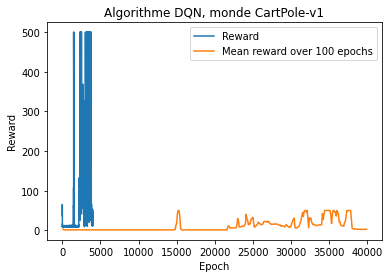

In [6]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
config = load_yaml('configs/config_random_cartpole.yaml')
#config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 4000
arrReward, arrMeanReward = runDQN(config, device, nb_epochs, capacity=10000, layers=[32,32], mini_batch_size=64, C=1000, lr=0.001)

Saving in ./XP/LunarLander-v2/random_-1605468636_390752
tensorboard --logdir=./XP/LunarLander-v2/random_-1605468636_390752
0 rsum=-156.7185207131621, 61 actions 
1 rsum=-276.77564183704146, 65 actions 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

2 rsum=-98.0101113306892, 97 actions 
3 rsum=-154.90407250391578, 63 actions 
4 rsum=-128.76699947372836, 64 actions 
5 rsum=-55.49535332533138, 70 actions 
6 rsum=-278.62358486051477, 75 actions 
7 rsum=-367.093265594206, 185 actions 
8 rsum=-334.2822977083571, 145 actions 
9 rsum=-203.02434049894043, 93 actions 
End of test, mean reward over the last 10 actions: -205.36941878458865
New test time! 
10 rsum=-323.24092536565587, 99 actions 
11 rsum=-264.41782518683954, 97 actions 
12 rsum=-381.30423456253595, 102 actions 
13 rsum=-278.1058940847098, 125 actions 
14 rsum=-284.50037387018756, 120 actions 
15 rsum=-691.3883766351959, 295 actions 
16 rsum=-350.62917672167714, 123 actions 
17 rsum=-210.9649272404291, 123 actions 
18 rsum=-264.87799211424294, 103 actions 
19 rsum=-310.0916916483385, 114 actions 
End of test, mean reward over the last 10 actions: -335.95214174298115
New test time! 
20 rsum=-293.728374810466, 124 actions 
21 rsum=-248.5649187969863, 142 actions 
22 rsum=-258.42

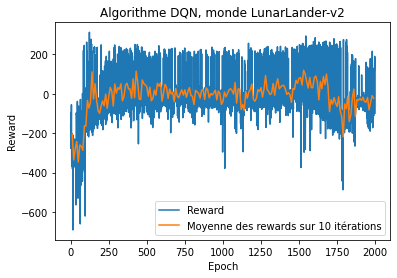

In [35]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
#config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
config = load_yaml('TME4env/configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 2000
arrReward, arrMeanReward = runDQN(config, device, nb_epochs, capacity=10000, layers=[32,32], mini_batch_size=64, C=1000, lr=0.001)

In [ ]:
#config = load_yaml('TME4env/configs/config_random_gridworld.yaml')
#config = load_yaml('TME4env/configs/config_random_cartpole.yaml')
config = load_yaml('configs/config_random_lunar.yaml')
device = torch.device('cpu')
nb_epochs = 3000
arrReward, arrMeanReward = runDQN(config, device, nb_epochs, capacity=10000, layers=[32,32], mini_batch_size=64, C=1000, lr=0.001)